# Meta-Labeling for bet side and size

Implementation of Triple-barrier method for determining side and Meta-labeling for size of the bet. Meta-labeling is a technique introduced by Marco Lopez De Prado in Advances to Financial machine learning.

## Imports

In [92]:
%load_ext autoreload
%autoreload 2

# standard imports
from pathlib import PurePath, Path 
import sys
import time
from collections import OrderedDict as od 
import re 
import os 
import json 

# scientific stack
import pandas as pd 
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import math
import mlfinlab as ml
import sklearn as sk
import pyfolio as pf

# visual tools and plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


C:\Users\seanm\anaconda3\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


## Import Dataset

In [93]:
# read in and store raw tick data in pandas dataframe to be cleaned and transformed
raw_tick_data = pd.read_csv('tick_data.csv')
raw_tick_data['date_time'] = pd.to_datetime(raw_tick_data.date_time)
raw_tick_data.set_index('date_time', drop=True, inplace=True)
print(raw_tick_data)

                            open     high      low    close  cum_vol  \
date_time                                                              
2011-07-31 23:31:58.810  1306.00  1308.75  1301.75  1305.75    53658   
2011-08-01 02:55:17.443  1305.75  1309.50  1304.00  1306.50    53552   
2011-08-01 07:25:56.319  1306.75  1309.75  1304.75  1305.00    53543   
2011-08-01 08:33:10.903  1305.00  1305.00  1299.00  1300.00    53830   
2011-08-01 10:51:41.842  1300.00  1307.75  1299.00  1307.75    53734   
...                          ...      ...      ...      ...      ...   
2012-07-30 12:30:28.642  1379.25  1380.00  1377.50  1377.75    50843   
2012-07-30 13:29:21.258  1377.75  1380.00  1377.00  1379.25    50782   
2012-07-30 13:35:05.407  1379.25  1383.25  1379.00  1382.50    50675   
2012-07-30 13:43:43.711  1382.50  1383.25  1380.00  1381.00    50667   
2012-07-30 13:54:26.158  1380.75  1381.75  1379.75  1380.75    50698   

                          cum_dollar  cum_ticks  
date_time    

## Create Dollar Bars

Here we transform the raw ohlc data into various financial data structures that provide a better representation of the movement of trade information throughout the market.  These bars include: dollar, tick, and volume bars.

## Fitting the Primary Model

This is is the primary model that we will use to drive our strategy (EMA Crossover)

In [94]:
fast_window = 12
slow_window = 26

raw_tick_data['fast_mavg'] = raw_tick_data['close'].rolling(window=fast_window, min_periods=fast_window, center=False).mean()
raw_tick_data['slow_mavg'] = raw_tick_data['close'].rolling(window=slow_window, min_periods=slow_window, center=False).mean()

### Compute side

In [95]:
raw_tick_data['side'] = np.nan
long_signals = raw_tick_data['fast_mavg'] >= raw_tick_data['slow_mavg']
short_signals = raw_tick_data['fast_mavg'] < raw_tick_data['slow_mavg']
raw_tick_data.loc[long_signals, 'side'] = 1
raw_tick_data.loc[short_signals, 'side'] = -1
data = raw_tick_data.dropna()
raw_data = data.copy()
print(long_signals)

date_time
2011-07-31 23:31:58.810    False
2011-08-01 02:55:17.443    False
2011-08-01 07:25:56.319    False
2011-08-01 08:33:10.903    False
2011-08-01 10:51:41.842    False
                           ...  
2012-07-30 12:30:28.642     True
2012-07-30 13:29:21.258    False
2012-07-30 13:35:05.407    False
2012-07-30 13:43:43.711    False
2012-07-30 13:54:26.158    False
Length: 10000, dtype: bool


In [96]:
# set daily volatility
daily_vol = ml.util.get_daily_vol(close=data['close'], lookback=50)
print(daily_vol)

date_time
2011-08-02 14:49:14.665         NaN
2011-08-02 14:55:22.761    0.000009
2011-08-02 15:02:12.277    0.000013
2011-08-02 15:07:17.932    0.001585
2011-08-02 15:12:42.641    0.001509
                             ...   
2012-07-30 12:30:28.642    0.008794
2012-07-30 13:29:21.258    0.009193
2012-07-30 13:35:05.407    0.009381
2012-07-30 13:43:43.711    0.009588
2012-07-30 13:54:26.158    0.009764
Name: close, Length: 9926, dtype: float64


In [97]:
# convert from daily vol to hourly vol (since our data in hourly)
trading_hours_in_day = 8
trading_days_in_year = 252
hourly_vol = daily_vol / math.sqrt(trading_hours_in_day * trading_days_in_year)
hourly_vol_mean = hourly_vol.mean()
print(hourly_vol)

date_time
2011-08-02 14:49:14.665             NaN
2011-08-02 14:55:22.761    2.095284e-07
2011-08-02 15:02:12.277    2.818900e-07
2011-08-02 15:07:17.932    3.530381e-05
2011-08-02 15:12:42.641    3.359834e-05
                               ...     
2012-07-30 12:30:28.642    1.958661e-04
2012-07-30 13:29:21.258    2.047418e-04
2012-07-30 13:35:05.407    2.089223e-04
2012-07-30 13:43:43.711    2.135460e-04
2012-07-30 13:54:26.158    2.174610e-04
Name: close, Length: 9926, dtype: float64


### Apply CUSUM Filter

The purpose of the CUSUM filter is to locate instances of change detection.  These are points that will later be used as t_events for the Triple-barrier method.

In [98]:
# apply symetric CUSUM filter and get timestamps for events
cusum_events = ml.filters.cusum_filter(data['close'], threshold=hourly_vol_mean * 0.5)
cusum_events

DatetimeIndex(['2011-08-01 14:54:45.324000', '2011-08-01 15:01:17.292000',
               '2011-08-01 15:05:30.877000', '2011-08-01 15:11:41.236000',
               '2011-08-01 15:26:40.200000', '2011-08-01 15:34:37.446000',
               '2011-08-01 15:38:23.090000', '2011-08-01 15:56:25.240000',
               '2011-08-01 16:16:58.143000', '2011-08-01 16:29:55.276000',
               ...
               '2012-07-27 20:01:25.794000', '2012-07-27 20:14:35.480000',
               '2012-07-30 06:13:28.136000', '2012-07-30 08:10:13.266000',
               '2012-07-30 10:16:04.616000', '2012-07-30 12:30:28.642000',
               '2012-07-30 13:29:21.258000', '2012-07-30 13:35:05.407000',
               '2012-07-30 13:43:43.711000', '2012-07-30 13:54:26.158000'],
              dtype='datetime64[ns]', length=9523, freq=None)

In [99]:
# compute vertical barrier
vertical_barriers = ml.labeling.add_vertical_barrier(t_events=cusum_events, close=data['close'], num_days=1)
vertical_barriers

2011-08-01 14:54:45.324   2011-08-02 14:55:22.761
2011-08-01 15:01:17.292   2011-08-02 15:02:12.277
2011-08-01 15:05:30.877   2011-08-02 15:07:17.932
2011-08-01 15:11:41.236   2011-08-02 15:12:42.641
2011-08-01 15:26:40.200   2011-08-02 15:27:24.004
                                    ...          
2012-07-27 19:53:34.640   2012-07-30 06:13:28.136
2012-07-27 19:57:45.879   2012-07-30 06:13:28.136
2012-07-27 19:59:58.054   2012-07-30 06:13:28.136
2012-07-27 20:01:25.794   2012-07-30 06:13:28.136
2012-07-27 20:14:35.480   2012-07-30 06:13:28.136
Name: date_time, Length: 9515, dtype: datetime64[ns]

### Set Take Profit and Stop Loss

In [100]:
pt_sl = [1,2]
min_ret = 0.005

### Get Triple-barrier Events using CUSUM filter

In [101]:
triple_barrier_events = ml.labeling.get_events(close=data['close'],
                                                t_events=cusum_events,
                                                pt_sl=pt_sl,
                                                #check between hourly and daily vol
                                                target=daily_vol,
                                                min_ret=min_ret,
                                                num_threads=3,
                                                vertical_barrier_times=vertical_barriers,
                                                side_prediction=data['side'],
                                                verbose=True
                                                )

labels = ml.labeling.get_bins(triple_barrier_events, data['close'])
labels

2020-10-08 02:01:31.862616 100.0% apply_pt_sl_on_t1 done after 0.13 minutes. Remaining 0.0 minutes..


,ret,trgt,bin,side
2011-08-02 19:31:14.387,0.005400,0.005069,1,-1.0
2011-08-02 19:42:30.586,0.006422,0.006108,1,-1.0
2011-08-02 19:45:56.176,0.007222,0.006424,1,-1.0
2011-08-02 19:50:37.185,0.009869,0.006789,1,-1.0
2011-08-02 19:52:57.011,0.009063,0.007127,1,-1.0
...,...,...,...,...
2012-07-27 19:53:34.640,-0.001991,0.005877,0,1.0
2012-07-27 19:57:45.879,-0.001268,0.005763,0,1.0
2012-07-27 19:59:58.054,-0.001810,0.005655,0,1.0
2012-07-27 20:01:25.794,-0.002713,0.005590,0,1.0


## Results of the Primary Model

In [102]:
# set variables for analysis
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

In [103]:
# performance metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']

#### Classification Report

In [104]:
print('CLassification Report')
print(sk.metrics.classification_report(y_true=actual,  y_pred=pred, zero_division=False))

CLassification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4659
           1       0.40      1.00      0.58      3162

    accuracy                           0.40      7821
   macro avg       0.20      0.50      0.29      7821
weighted avg       0.16      0.40      0.23      7821



#### Confusion Matrix

In [105]:
print('Confusion Matrix')
sk.metrics.confusion_matrix(actual, pred)

Confusion Matrix


array([[   0, 4659],
       [   0, 3162]], dtype=int64)

#### Accuracy

In [106]:
print('Accuracy')
sk.metrics.accuracy_score(actual, pred)

Accuracy


0.40429612581511315

## Fit the Meta Model (Train Forest for bet size)

In [107]:
# get log of returns
raw_data['log_ret'] = np.log(raw_data['close']).diff()

In [108]:
# create momentum columns
raw_data['mom1'] = raw_data['close'].pct_change(periods=1)
raw_data['mom2'] = raw_data['close'].pct_change(periods=2)
raw_data['mom3'] = raw_data['close'].pct_change(periods=3)
raw_data['mom4'] = raw_data['close'].pct_change(periods=4)
raw_data['mom5'] = raw_data['close'].pct_change(periods=5)

In [109]:
# create volatility columns
raw_data['volatility_50'] = raw_data['log_ret'].rolling(window=50, min_periods=50, center=False).std()
raw_data['volatility_31'] = raw_data['log_ret'].rolling(window=31, min_periods=31, center=False).std()
raw_data['volatility_15'] = raw_data['log_ret'].rolling(window=15, min_periods=15, center=False).std()

In [110]:
# serial Correlation (Takes about 4 minutes)
window_autocorr = 50

raw_data['autocorr_1'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
raw_data['autocorr_2'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
raw_data['autocorr_3'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)
raw_data['autocorr_4'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=4), raw=False)
raw_data['autocorr_5'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=5), raw=False)

In [111]:
# serial Correlation (Takes about 4 minutes)
window_autocorr = 50

raw_data['autocorr_1'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
raw_data['autocorr_2'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
raw_data['autocorr_3'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)
raw_data['autocorr_4'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=4), raw=False)
raw_data['autocorr_5'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=5), raw=False)

### Recompute sides

In [112]:
raw_data['side'] = np.nan
long_signals = raw_data['fast_mavg'] >= raw_data['slow_mavg']
short_signals = raw_data['fast_mavg'] < raw_data['slow_mavg']
raw_data.loc[long_signals, 'side'] = 1
raw_data.loc[short_signals, 'side'] = -1

In [113]:
long_signals

date_time
2011-08-01 14:46:00.072    False
2011-08-01 14:54:45.324    False
2011-08-01 15:01:17.292    False
2011-08-01 15:05:30.877    False
2011-08-01 15:11:41.236    False
                           ...  
2012-07-30 12:30:28.642     True
2012-07-30 13:29:21.258    False
2012-07-30 13:35:05.407    False
2012-07-30 13:43:43.711    False
2012-07-30 13:54:26.158    False
Length: 9975, dtype: bool

In [114]:
# remove look ahead bias
raw_data = raw_data.shift(1)

In [115]:
# get features at event times
x = raw_data.loc[labels.index, :]
x.head()

,open,high,low,close,cum_vol,cum_dollar,cum_ticks,fast_mavg,slow_mavg,side,...,mom4,mom5,volatility_50,volatility_31,volatility_15,autocorr_1,autocorr_2,autocorr_3,autocorr_4,autocorr_5
2011-08-02 19:31:14.387,1260.50,1261.00,1256.25,1257.75,55642.0,70005634.0,10617.0,1261.895833,1265.211538,-1.0,...,-0.002577,-0.004945,0.001702,0.001583,0.001996,0.029843,-0.197186,-0.158058,0.136121,-0.010434
2011-08-02 19:42:30.586,1256.75,1258.75,1256.50,1256.75,55659.0,70002253.0,9989.0,1260.437500,1264.134615,-1.0,...,-0.005342,-0.004160,0.001701,0.001562,0.001831,0.030560,-0.191755,-0.160330,0.168595,0.007442
2011-08-02 19:45:56.176,1256.75,1257.00,1253.50,1253.75,55769.0,70009359.0,6933.0,1259.750000,1263.538462,-1.0,...,-0.005355,-0.007717,0.001723,0.001578,0.001750,0.026686,-0.181886,-0.124395,0.193267,-0.017387
2011-08-02 19:50:37.185,1253.75,1255.75,1253.75,1255.25,55790.0,70001893.0,8166.0,1259.250000,1263.000000,-1.0,...,-0.001988,-0.004165,0.001735,0.001608,0.001785,-0.014724,-0.195696,-0.120401,0.168655,-0.038602
2011-08-02 19:52:57.011,1255.25,1256.25,1253.25,1253.50,55816.0,70033348.5,8558.0,1258.854167,1262.394231,-1.0,...,-0.002586,-0.003379,0.001658,0.001593,0.001798,-0.103627,-0.143611,-0.131545,0.190062,-0.147810


In [116]:
# remove unwanted columns
x.drop(['open', 'high', 'low', 'close', 'cum_vol', 'cum_dollar', 'cum_ticks','fast_mavg', 'slow_mavg'], axis=1, inplace=True)
y = labels['bin']
x.head()

,side,log_ret,mom1,mom2,mom3,mom4,mom5,volatility_50,volatility_31,volatility_15,autocorr_1,autocorr_2,autocorr_3,autocorr_4,autocorr_5
2011-08-02 19:31:14.387,-1.0,-0.002184,-0.002182,-0.004551,-0.003368,-0.002577,-0.004945,0.001702,0.001583,0.001996,0.029843,-0.197186,-0.158058,0.136121,-0.010434
2011-08-02 19:42:30.586,-1.0,0.000000,0.000000,-0.000795,-0.002975,-0.005342,-0.004160,0.001701,0.001562,0.001831,0.030560,-0.191755,-0.160330,0.168595,0.007442
2011-08-02 19:45:56.176,-1.0,-0.002390,-0.002387,-0.002387,-0.003180,-0.005355,-0.007717,0.001723,0.001578,0.001750,0.026686,-0.181886,-0.124395,0.193267,-0.017387
2011-08-02 19:50:37.185,-1.0,0.001196,0.001196,-0.001194,-0.001194,-0.001988,-0.004165,0.001735,0.001608,0.001785,-0.014724,-0.195696,-0.120401,0.168655,-0.038602
2011-08-02 19:52:57.011,-1.0,-0.001395,-0.001394,-0.000199,-0.002586,-0.002586,-0.003379,0.001658,0.001593,0.001798,-0.103627,-0.143611,-0.131545,0.190062,-0.147810


In [117]:
# print the y values (0, 1)
y.value_counts()

0    4659
1    3162
Name: bin, dtype: int64

### Model Training

Here we will strart by seperating our dataset in a training and test set for the purpose of implementing our random forest and checking itts abiility to accurately make predictions on the test set.

#### Split into training and test set

In [118]:
raw_data = raw_data.dropna()
x_training_validation = x
y_training_validation = y

In [119]:
# function to create train, test, and split data from scikit-learn
x_train, x_validate, y_train, y_validate = sk.model_selection.train_test_split(
                                        x_training_validation, 
                                        y_training_validation,
                                        test_size=0.70,
                                        train_size=0.30,  
                                        shuffle=False)

In [120]:
# create train dataframe
train_df = pd.concat([y_train,x_train], axis=1, join='inner')
train_df['bin'].value_counts()

1    1198
0    1148
Name: bin, dtype: int64

#### Unsample training data for 50/50 split

In [121]:
majority = train_df[train_df['bin'] == 0]
minority = train_df[train_df['bin'] == 1]

In [122]:
majority = train_df[train_df['bin'] == 0]
minority = train_df[train_df['bin'] == 1]

new_minority = sk.utils.resample(minority,
                        replace=True,
                        n_samples=majority.shape[0], # to match majority class
                        random_state=42) # figure random state out

train_df = pd.concat([majority, new_minority])
train_df = sk.utils.shuffle(train_df, random_state=42)

In [123]:
train_df.head()

,bin,side,log_ret,mom1,mom2,mom3,mom4,mom5,volatility_50,volatility_31,volatility_15,autocorr_1,autocorr_2,autocorr_3,autocorr_4,autocorr_5
2011-08-10 14:36:47.974,1,-1.0,0.005515,0.005530,0.008877,0.008653,0.004197,0.003754,0.004277,0.004253,0.004030,-0.058383,0.259625,0.197343,-0.028577,0.207175
2011-09-22 19:42:53.742,1,-1.0,-0.001346,-0.001345,0.002701,0.005191,0.002025,-0.002017,0.002600,0.002863,0.003447,-0.079335,-0.031593,-0.015003,-0.200752,-0.015650
2011-08-11 13:45:03.082,0,-1.0,-0.003957,-0.003949,0.004647,0.007098,0.003315,0.011586,0.005408,0.006099,0.006557,-0.148196,0.317933,0.146384,-0.075825,-0.047033
2011-09-14 15:17:47.762,0,-1.0,0.003649,0.003656,0.004088,0.004088,0.004304,0.004304,0.003066,0.003526,0.002373,-0.035688,0.018795,0.021615,-0.288160,-0.211125
2011-08-04 14:42:19.868,1,-1.0,0.000809,0.000810,0.003247,0.003450,0.002636,0.000405,0.002492,0.002647,0.001792,-0.052389,-0.010864,0.088076,-0.150908,-0.051367


In [124]:
train_df['bin'].value_counts()

1    1148
0    1148
Name: bin, dtype: int64

#### Create Training Data

In [125]:
y_train = train_df['bin']
x_train = train_df.loc[:, train_df.columns != 'bin']

In [126]:
# fit the model
parameters = {'max_depth': [2, 3, 4, 5, 7],
                'n_estimators': [1, 10, 25, 50, 100],
                'random_state': [42] }


In [127]:
def perform_grid_search(x_data, y_data):
        rf = sk.ensemble.RandomForestClassifier()

        clf = sk.model_selection.GridSearchCV(rf, parameters, cv=4, scoring='roc_auc', n_jobs=3)

        clf.fit(x_data, y_data)

        print(clf.cv_results_['mean_test_score'])
        print(clf.best_params_['n_estimators'])
        print(clf.best_params_['max_depth'])

        return clf.best_params_['n_estimators'], clf.best_params_['max_depth']

#### Extract Parameters

In [128]:
n_estimator, depth = perform_grid_search(x_train, y_train)
c_random_state = 42
print('n_estimator: ' + str(n_estimator), '\ndepth: ' + str(depth), '\nc_random_state: ' + str(c_random_state))

[0.56058104 0.66547791 0.67335405 0.69237668 0.70558098 0.58709284
 0.70428043 0.74764474 0.76091734 0.76848086 0.60694557 0.75213673
 0.79169955 0.80519674 0.81091187 0.64009215 0.79356311 0.83445076
 0.84175175 0.84711785 0.68694988 0.85647817 0.88293533 0.88940621
 0.89581335]
100
7
n_estimator: 100 
depth: 7 
c_random_state: 42


#### Refit new model with best params

In [129]:
rf = sk.ensemble.RandomForestClassifier(max_depth=depth, n_estimators=n_estimator, random_state=c_random_state)
rf.fit(x_train, y_train.values.ravel())

RandomForestClassifier(max_depth=7, random_state=42)

### Training Metrics

In [130]:
y_pred_rf = rf.predict_proba(x_train)[:, 1]
y_pred = rf.predict(x_train)
fpr_rf, tpr_rf, _ = sk.metrics.roc_curve(y_train, y_pred_rf)

print('Classification Report')
print(sk.metrics.classification_report(y_train, y_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.95      0.93      1148
           1       0.95      0.90      0.92      1148

    accuracy                           0.92      2296
   macro avg       0.93      0.92      0.92      2296
weighted avg       0.93      0.92      0.92      2296



In [131]:
print('Confusion Matrix')
print(sk.metrics.confusion_matrix(y_train, y_pred))

Confusion Matrix
[[1090   58]
 [ 115 1033]]


In [132]:
print('Accuracy')
print(sk.metrics.accuracy_score(y_train, y_pred))

Accuracy
0.9246515679442509


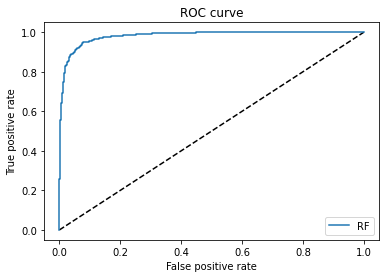

In [133]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [134]:
print('Timestamp of min value :' + ' ' + str(x_validate.index.min()), '\nTimestamp of max value :' + ' ' + str(x_validate.index.max()))

Timestamp of min value : 2011-10-05 14:05:40.611000 
Timestamp of max value : 2012-07-27 20:14:35.480000


### Meta-label 

These are the results of the model with meta-labeling for size

#### Performance Metrics

In [135]:
y_pred_rf = rf.predict_proba(x_validate)[:, 1]
y_pred = rf.predict(x_validate)

fpr_rf, tpr_rf, _ = sk.metrics.roc_curve(y_validate, y_pred_rf)

print(sk.metrics.classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.47      0.54      3511
           1       0.36      0.54      0.43      1964

    accuracy                           0.49      5475
   macro avg       0.50      0.50      0.49      5475
weighted avg       0.54      0.49      0.50      5475



#### Confusion Matrix

In [136]:
print(sk.metrics.confusion_matrix(y_validate, y_pred))

[[1650 1861]
 [ 912 1052]]


#### Accuracy

In [137]:
print(sk.metrics.accuracy_score(y_validate, y_pred))

0.4935159817351598


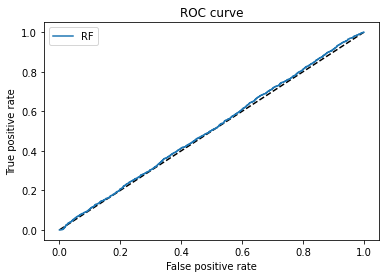

In [138]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [139]:
print('x_validate_min :' + ' ' + str(x_validate.index.min()), '\nx_validate_max :' + ' ' + str(x_validate.index.max()))

x_validate_min : 2011-10-05 14:05:40.611000 
x_validate_max : 2012-07-27 20:14:35.480000


In [140]:
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']
print(labels)

                              ret      trgt  bin  side
2011-08-02 19:31:14.387  0.005400  0.005069    1  -1.0
2011-08-02 19:42:30.586  0.006422  0.006108    1  -1.0
2011-08-02 19:45:56.176  0.007222  0.006424    1  -1.0
2011-08-02 19:50:37.185  0.009869  0.006789    1  -1.0
2011-08-02 19:52:57.011  0.009063  0.007127    1  -1.0
...                           ...       ...  ...   ...
2012-07-27 19:53:34.640 -0.001991  0.005877    0   1.0
2012-07-27 19:57:45.879 -0.001268  0.005763    0   1.0
2012-07-27 19:59:58.054 -0.001810  0.005655    0   1.0
2012-07-27 20:01:25.794 -0.002713  0.005590    0   1.0
2012-07-27 20:14:35.480 -0.002893  0.005528    0   1.0

[7821 rows x 4 columns]


Set the time period for primary forecast

In [141]:
start = primary_forecast.index.get_loc('2011-08-02 19:31:14.387')
end = primary_forecast.index.get_loc('2012-07-27 20:14:35.480') + 1

In [142]:
subset_prim = primary_forecast[start:end]

### Performance Metrics

In [143]:
actual = subset_prim['actual']
pred = subset_prim['pred']
print(sk.metrics.classification_report(y_true=actual, y_pred=pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4659
           1       0.40      1.00      0.58      3162

    accuracy                           0.40      7821
   macro avg       0.20      0.50      0.29      7821
weighted avg       0.16      0.40      0.23      7821



C:\Users\seanm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Confusion Matrix

In [144]:
print(sk.metrics.confusion_matrix(actual, pred))

[[   0 4659]
 [   0 3162]]


#### Accuracy

In [145]:
print(sk.metrics.accuracy_score(actual, pred))

0.40429612581511315


## Feature Importance

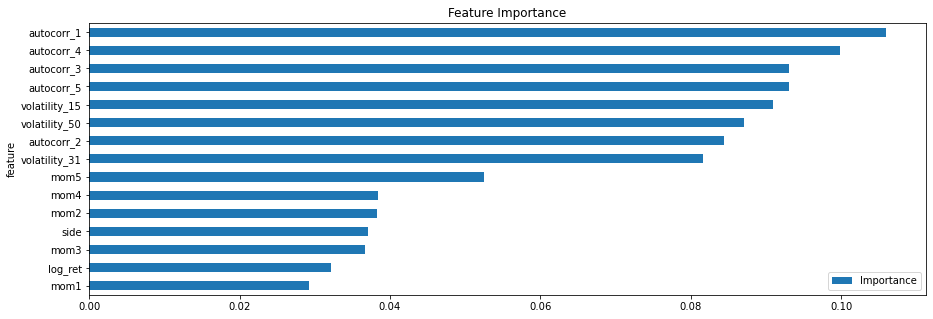

In [146]:
title = 'Feature Importance'
figsize = (15,5)

feat_imp = pd.DataFrame({'Importance':rf.feature_importances_})
feat_imp['feature'] = x.columns
feat_imp.sort_values(by="Importance", ascending=False, inplace=True)
feat_imp = feat_imp

feat_imp.sort_values(by='Importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title=title, figsize=figsize)

### Perfromance Sheet

In [147]:
def get_daily_returns(intraday_returns):
        """
        Daily returns for pyfolio
        """
        cum_rets = ((intraday_returns + 1).cumprod())
        # Downsample to daily
        daily_rets = cum_rets.resample('B').last()
        # Forward fill, Percent change, Drop NaN
        daily_rets = daily_rets.ffill().pct_change().dropna()
        return daily_rets

In [148]:
valid_dates = x_validate.index
base_rets = labels.loc[valid_dates, 'ret']
primary_model_rets = get_daily_returns(base_rets)

In [149]:
# Set up the function to extract the KPI's from pyfolio
perf_func = pf.timeseries.perf_stats

In [150]:
# Save the statistics in a dataframe
perf_stats_all = perf_func(returns=primary_model_rets, 
                        factor_returns=None, 
                        positions=None,
                        transactions=None,
                        turnover_denom="AGB")

perf_stats_df = pd.DataFrame(data=perf_stats_all, columns=['Primary Model'])
pf.show_perf_stats(primary_model_rets)

Start date,2011-10-06
End date,2012-07-27
Total months,10
,Backtest
Annual return,353.6%
Cumulative returns,256.8%
Annual volatility,246.5%
Sharpe ratio,1.71
Calmar ratio,4.26
Stability,0.23
Max drawdown,-83.1%


### With Meta-labeling

In [151]:
meta_returns = labels.loc[valid_dates, 'ret'] * y_pred
daily_meta_rets = get_daily_returns(meta_returns)

# Save KPIs in a dataframe
erf_stats_all = perf_func(returns=daily_meta_rets, 
                        factor_returns=None, 
                        positions=None,
                        transactions=None,
                        turnover_denom="AGB")

perf_stats_df['Meta Model'] = perf_stats_all

pf.show_perf_stats(daily_meta_rets)

Start date,2011-10-06
End date,2012-07-27
Total months,10
,Backtest
Annual return,-64.9%
Cumulative returns,-58.5%
Annual volatility,182.5%
Sharpe ratio,0.26
Calmar ratio,-0.82
Stability,0.21
Max drawdown,-79.6%


### Out of Sample Test

#### Meta Model Metrics

In [152]:
# extract out of sample data
x_oos = x
y_oos = y

# Performance Metrics
y_pred_rf = rf.predict_proba(x_oos)[:, 1]
y_pred = rf.predict(x_oos)
fpr_rf, tpr_rf, _ = sk.metrics.roc_curve(y_oos, y_pred_rf)
print(sk.metrics.classification_report(y_oos, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.59      0.64      4659
           1       0.51      0.63      0.57      3162

    accuracy                           0.61      7821
   macro avg       0.61      0.61      0.60      7821
weighted avg       0.63      0.61      0.61      7821



#### Confusion Matrix

In [153]:
print(sk.metrics.confusion_matrix(y_oos, y_pred))

[[2740 1919]
 [1158 2004]]


#### Accuracy

In [154]:
print(sk.metrics.accuracy_score(y_oos, y_pred))

0.6065720496100243


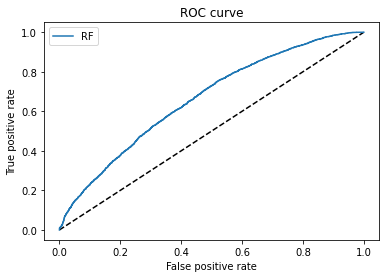

In [155]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()